## Fusing BBoxes (Pre-Processing)

In [ ]:
!pip install ensemble-boxes

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import cv2
import json
import pandas as pd
import glob
import os.path as osp
from path import Path
import datetime
import numpy as np
from tqdm.auto import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split

from ensemble_boxes import *
import warnings
from collections import Counter

In [2]:
train_annotations = pd.read_csv("xray/train.csv")
train_annotations.head(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691,1375,1653,1831
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264,743,1611,1019
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627,357,947,433
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347,245,2188,2169
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557,2352,675,2484


In [3]:
train_annotations = train_annotations[train_annotations.class_id!=14]
train_annotations['image_path'] = train_annotations['image_id'].map(lambda x:os.path.join('xray/train2017', str(x)+'.jpg'))
train_annotations.head(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691,1375,1653,1831,xray/train2017/9a5094b2563a1ef3ff50dc5c7ff7134...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264,743,1611,1019,xray/train2017/051132a778e61a86eb147c7c6f564df...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627,357,947,433,xray/train2017/1c32170b4af4ce1a3030eb8167753b0...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347,245,2188,2169,xray/train2017/0c7a38f293d5f5e4846aa4ca6db4daf...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557,2352,675,2484,xray/train2017/47ed17dcb2cbeec15182ed335a8b5a9...


In [4]:
imagepaths = train_annotations['image_path'].unique()
print("Number of Images with abnormalities:",len(imagepaths))
anno_count = train_annotations.shape[0]
print("Number of Annotations with abnormalities:", anno_count)

Number of Images with abnormalities: 4394
Number of Annotations with abnormalities: 36096


In [5]:
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output

In [6]:
labels =  [
            "Aortic_enlargement",
            "Atelectasis",
            "Calcification",
            "Cardiomegaly",
            "Consolidation",
            "ILD",
            "Infiltration",
            "Lung_Opacity",
            "Nodule/Mass",
            "Other_lesion",
            "Pleural_effusion",
            "Pleural_thickening",
            "Pneumothorax",
            "Pulmonary_fibrosis"
            ]
viz_labels = labels[:]

xray/train2017/9a5094b2563a1ef3ff50dc5c7ff71345.jpg
xray/train2017/051132a778e61a86eb147c7c6f564dfe.jpg
xray/train2017/1c32170b4af4ce1a3030eb8167753b06.jpg
xray/train2017/0c7a38f293d5f5e4846aa4ca6db4daf1.jpg
xray/train2017/47ed17dcb2cbeec15182ed335a8b5a9e.jpg
xray/train2017/d3637a1935a905b3c326af31389cb846.jpg


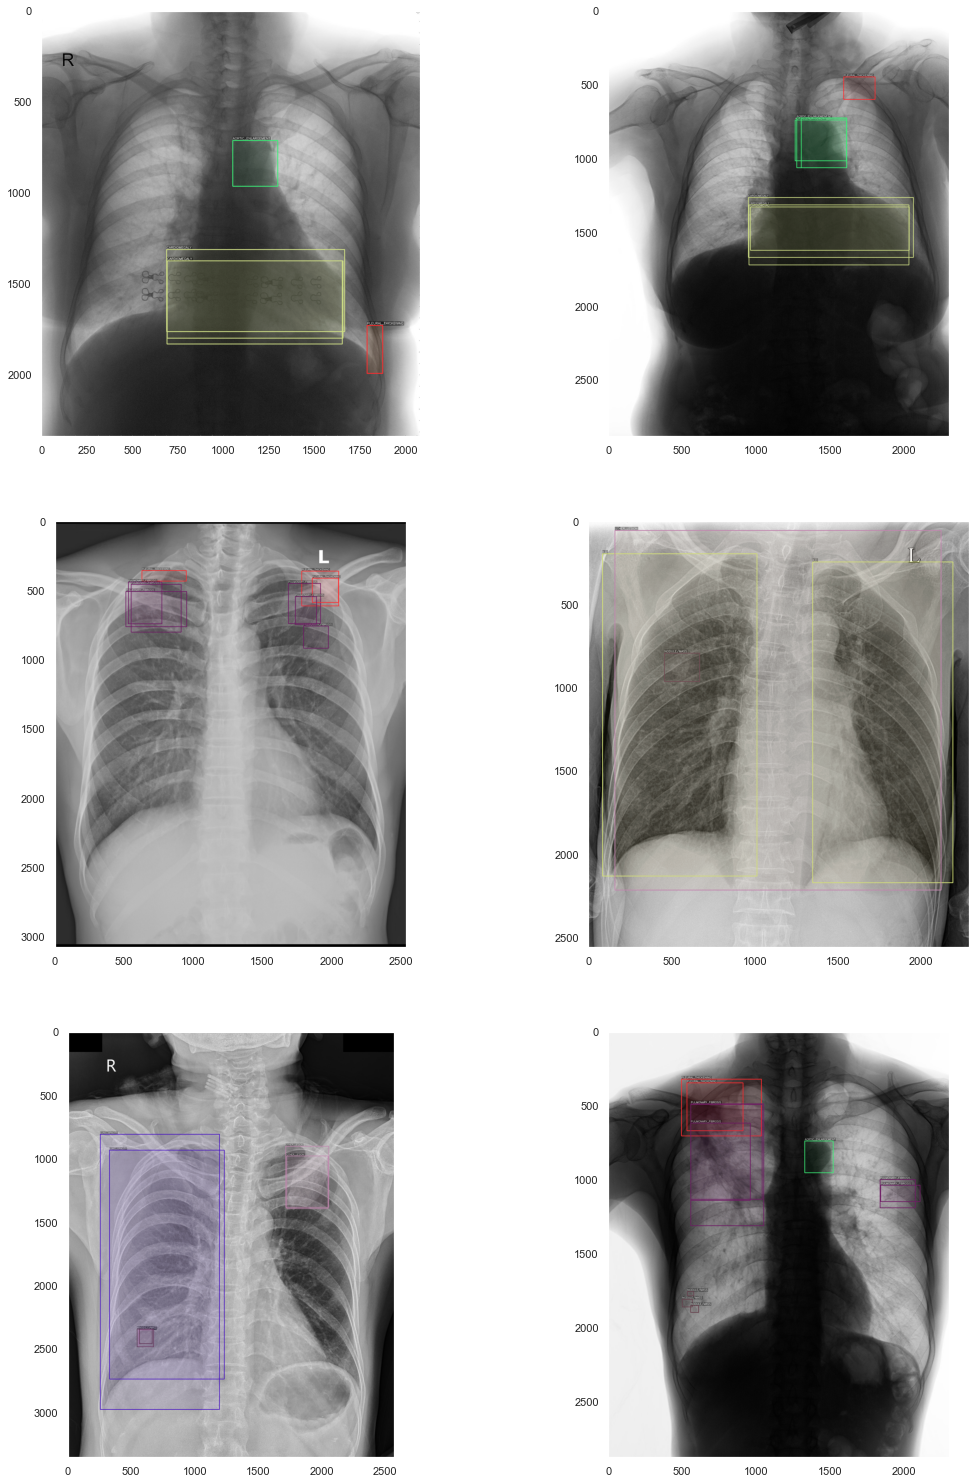

In [7]:
# map label_id to specify color
#label2color = [[random.randint(0,255) for i in range(3)] for class_id in viz_labels]
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]

thickness = 3
imgs = []

for img_id, path in zip(train_annotations['image_id'][:6], train_annotations['image_path'][:6]):
    print(path)

    boxes = train_annotations.loc[train_annotations['image_id'] == img_id,
                                  ['x_min', 'y_min', 'x_max', 'y_max']].values
    img_labels = train_annotations.loc[train_annotations['image_id'] == img_id, ['class_id']].values.squeeze()
    
    img = cv2.imread(path)
    
    for label_id, box in zip(img_labels, boxes):
        color = label2color[label_id]
        img = draw_bbox(img, list(np.int_(box)), viz_labels[label_id], color)
    imgs.append(img)

plot_imgs(imgs, size=9, cmap=None)
plt.show()

# Exploring Techniques to Combine Bboxes
## Non-maximum Suppression (NMS)

In [ ]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    print("Bboxes before nms:\n", boxes_viz)
    print("Labels before nms:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            
    # Perform NMS
    boxes, scores, box_labels = nms(boxes_list, scores_list, labels_list, weights=weights,
                                    iou_thr=iou_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    print("Bboxes after nms:\n", boxes)
    print("Labels after nms:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Non-max Suppression", va="top", ha="center", size=25)
plt.savefig('nms.png', bbox_inches='tight')
plt.show()

## Soft-NMS

In [ ]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
sigma = 0.1

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename]
    
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    print("Bboxes before soft_nms:\n", boxes_viz)
    print("Labels before soft_nms:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            
        
    # Perform Soft-NMS
    boxes, scores, box_labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights,
                                         iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
    
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()
    
    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    print("Bboxes after soft_nms:\n", boxes)
    print("Labels after soft_nms:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Soft NMS", va="top", ha="center", size=25)
plt.savefig('snms.png', bbox_inches='tight')
plt.show()

## Non-maximum Weighted

In [ ]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    print("Bboxes before non_maximum_weighted:\n", boxes_viz)
    print("Labels before non_maximum_weighted:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            

    # Perform Non-maximum Weighted
    boxes, scores, box_labels = non_maximum_weighted(boxes_list, scores_list, labels_list,
                                                     weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    print("Bboxes after non_maximum_weighted:\n", boxes)
    print("Labels after non_maximum_weighted:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Non-maximum Weighted", va="top", ha="center", size=25)
plt.savefig('nmw.png', bbox_inches='tight')
plt.show()

 ## Weighted boxes fusion (WBF)

In [ ]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
sigma = 0.1

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    print("Bboxes before WBF:\n", boxes_viz)
    print("Labels before WBF:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            

    # Perform WBF
    boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    print("Bboxes after WBF:\n", boxes)
    print("Labels after WBF:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.savefig('wbf.png', bbox_inches='tight')
plt.show()

### Weighted Boxes Fusion seems to give  gives better results comparing to others in this situation considering that we don't have the confidence/weights of the annotations done by different radiologists

## COCO dataset

In [8]:
random.seed(42)
## 42 -  The Answer to the Ultimate Question of Life
random.shuffle(imagepaths)
train_len = round(1*len(imagepaths))
# train_len = round(0.75*len(imagepaths))
train_paths = imagepaths[:train_len]
val_paths = imagepaths[train_len:]

print("Split Counts\nTrain Images:\t\t{0}\nVal Images:\t\t{1}"
      .format(len(train_paths), len(val_paths)))

Split Counts
Train Images:		4394
Val Images:		0


In [9]:
now = datetime.datetime.now()

data = dict(
    info=dict(
        description='fused',
        url=None,
        version=None,
        year=now.year,
        contributor=None,
        date_created=now.strftime('%Y-%m-%d %H:%M:%S.%f'),
    ),
    licenses=[dict(
        url=None,
        id=0,
        name=None,
    )],
    images=[
        # license, url, file_name, height, width, date_captured, id
    ],
    type='instances',
    annotations=[
        # segmentation, area, iscrowd, image_id, bbox, category_id, id
    ],
    categories=[
        # supercategory, id, name
    ],
)

In [10]:
class_name_to_id = {}
for i, each_label in enumerate(labels):
    class_id = i + 1  # starts with 1
    class_name = each_label
#     if class_id == -1:
#         assert class_name == '__ignore__'
#         continue
    class_name_to_id[class_name] = class_id
    data['categories'].append(dict(
        supercategory=None,
        id=class_id,
        name=class_name,
    ))

In [11]:
data

{'info': {'description': 'fused',
  'url': None,
  'version': None,
  'year': 2021,
  'contributor': None,
  'date_created': '2021-02-19 21:36:33.897438'},
 'licenses': [{'url': None, 'id': 0, 'name': None}],
 'images': [],
 'type': 'instances',
 'annotations': [],
 'categories': [{'supercategory': None, 'id': 1, 'name': 'Aortic_enlargement'},
  {'supercategory': None, 'id': 2, 'name': 'Atelectasis'},
  {'supercategory': None, 'id': 3, 'name': 'Calcification'},
  {'supercategory': None, 'id': 4, 'name': 'Cardiomegaly'},
  {'supercategory': None, 'id': 5, 'name': 'Consolidation'},
  {'supercategory': None, 'id': 6, 'name': 'ILD'},
  {'supercategory': None, 'id': 7, 'name': 'Infiltration'},
  {'supercategory': None, 'id': 8, 'name': 'Lung_Opacity'},
  {'supercategory': None, 'id': 9, 'name': 'Nodule/Mass'},
  {'supercategory': None, 'id': 10, 'name': 'Other_lesion'},
  {'supercategory': None, 'id': 11, 'name': 'Pleural_effusion'},
  {'supercategory': None, 'id': 12, 'name': 'Pleural_thic

In [ ]:
train_output_dir = "./vinbigdata_coco_chest_xray/train_images"
# val_output_dir = "./vinbigdata_coco_chest_xray/val_images"

if not osp.exists(train_output_dir):
    os.makedirs(train_output_dir)
    print('Coco Train Image Directory:', train_output_dir)
    
# if not osp.exists(val_output_dir):
#     os.makedirs(val_output_dir)
#     print('Coco Val Image Directory:', val_output_dir)

In [12]:
warnings.filterwarnings("ignore", category=UserWarning)

In [13]:
## Setting the output annotations json file path
train_out_file = 'train_annotations.json'

data_train = data.copy()
data_train['images'] = []
data_train['annotations'] = []

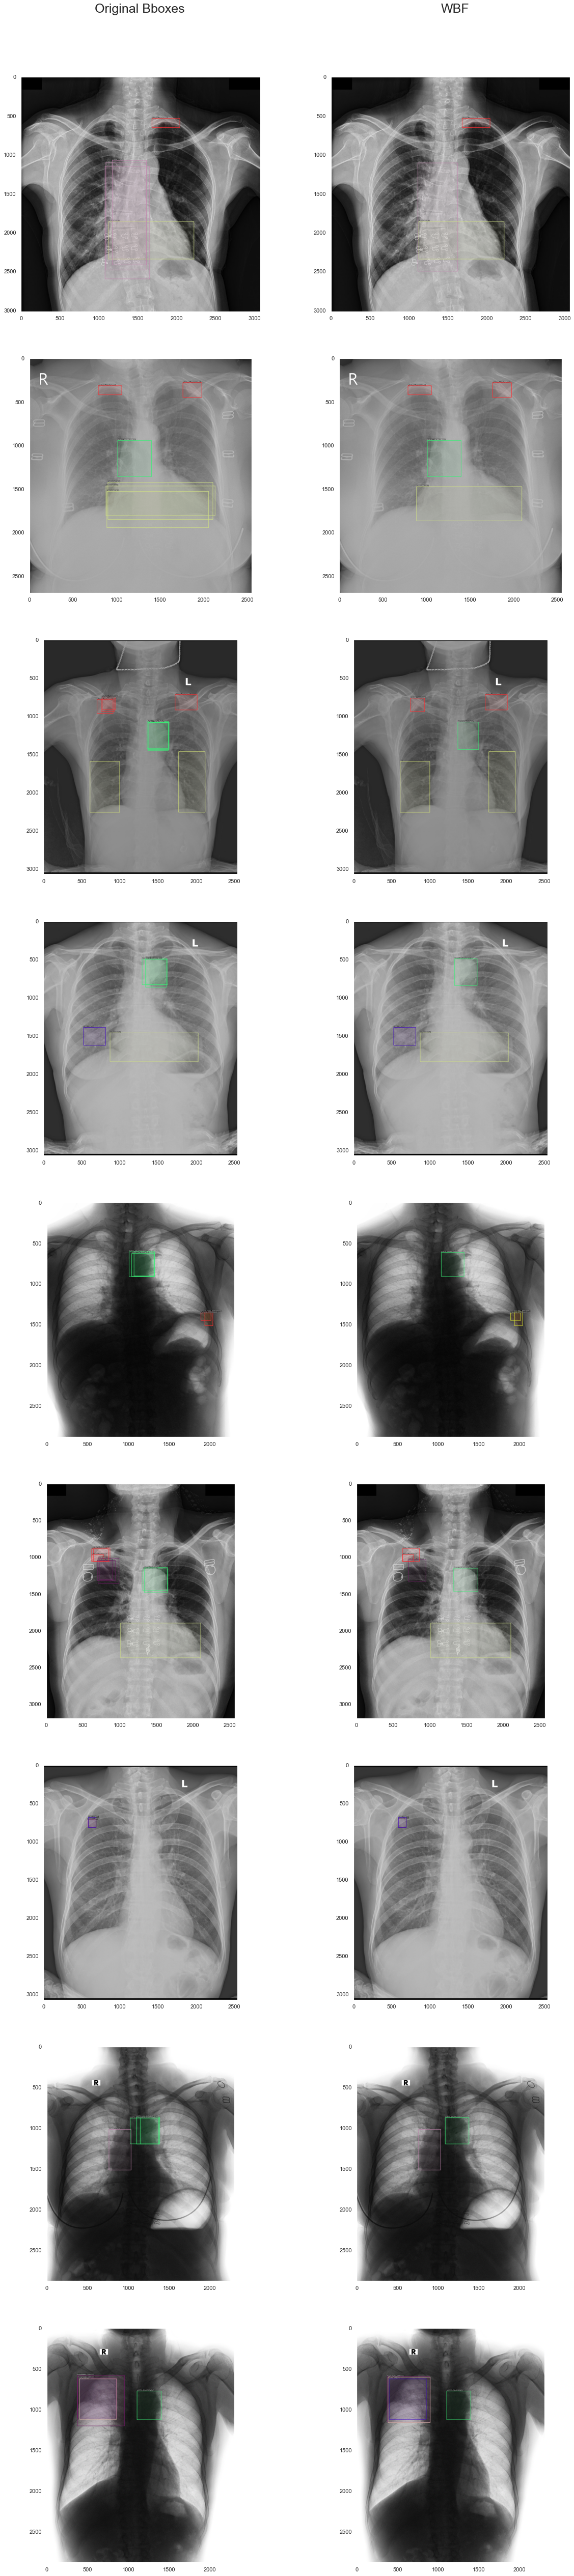

In [14]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(train_paths)):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    # print(image_basename)
#     print(f"(\'{image_basename}\', \'{path}\')")
    
    ## Copy Image 
    #shutil.copy2(path, train_output_dir)
    
    ## Add Images to annotation
    data_train['images'].append(dict(
        license=0,
        url=None,
        file_name=os.path.join(image_basename+'.jpg'),
        height=img_array.shape[0],
        width=img_array.shape[1],
        date_captured=None,
        id=i
    ))
    
    img_annotations = train_annotations[train_annotations.image_id==image_basename]
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    ## Visualize Original Bboxes every 500th
    if (i%500==0):
        img_before = img_array.copy()
        for box, label in zip(boxes_viz, labels_viz):
            x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
            color = label2color[int(label)]
            img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
        viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []

    cls_ids = img_annotations['class_id'].unique().tolist()
    
    count_dict = Counter(img_annotations['class_id'].tolist())

    for cid in cls_ids:
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())
            weights.append(1)
    
    ## Perform WBF
    boxes, scores, box_labels = weighted_boxes_fusion(boxes_list=boxes_list, scores_list=scores_list,
                                                  labels_list=labels_list, weights=weights,
                                                  iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()
    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        area = round((x_max-x_min)*(y_max-y_min),1)
        bbox =[
                round(x_min, 1),
                round(y_min, 1),
                round((x_max-x_min), 1),
                round((y_max-y_min), 1)
                ]
        
        data_train['annotations'].append(dict( id=len(data_train['annotations']), image_id=image_basename,
                                            category_id=int(label)+1, area=area, bbox=bbox,
                                            iscrowd=0))
        
    ## Visualize Bboxes after operation every 500th
    if (i%500==0):
        img_after = img_array.copy()
        for box, label in zip(boxes, box_labels):
            color = label2color[int(label)]
            img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
        viz_images.append(img_after)

plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.show()
               
with open(train_out_file, 'w') as f:
    json.dump(data_train, f, indent=4)

In [ ]:
## Setting the output annotations json file path
val_out_file = './vinbigdata_coco_chest_xray/val_annotations.json'

data_val = data.copy()
data_val['images'] = []
data_val['annotations'] = []

In [ ]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(val_paths)):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
#     print(f"(\'{image_basename}\', \'{path}\')")
    
    ## Copy Image 
    shutil.copy2(path, val_output_dir)
    
    ## Add Images to annotation
    data_val['images'].append(dict(
        license=0,
        url=None,
        file_name=os.path.join('val_images', image_basename+'.jpg'),
        height=img_array.shape[0],
        width=img_array.shape[1],
        date_captured=None,
        id=i
    ))
    
    img_annotations = train_annotations[train_annotations.image_id==image_basename]
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    ## Visualize Original Bboxes every 500th
    if (i%500==0):
        img_before = img_array.copy()
        for box, label in zip(boxes_viz, labels_viz):
            x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
            color = label2color[int(label)]
            img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
        viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []

    cls_ids = img_annotations['class_id'].unique().tolist()
    
    count_dict = Counter(img_annotations['class_id'].tolist())
    for cid in cls_ids:
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())
            weights.append(1)
            
    ## Perform WBF
    boxes, scores, box_labels = weighted_boxes_fusion(boxes_list=boxes_list, scores_list=scores_list,
                                                  labels_list=labels_list, weights=weights,
                                                  iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()
    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        area = round((x_max-x_min)*(y_max-y_min),1)
        bbox =[
                round(x_min, 1),
                round(y_min, 1),
                round((x_max-x_min), 1),
                round((y_max-y_min), 1)
                ]
        
        data_val['annotations'].append(dict( id=len(data_val['annotations']), image_id=i,
                                            category_id=int(label), area=area, bbox=bbox,
                                            iscrowd=0))
        
    ## Visualize Bboxes after operation
    if (i%500==0):
        img_after = img_array.copy()
        for box, label in zip(boxes, box_labels):
            color = label2color[int(label)]
            img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
        viz_images.append(img_after)
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.show()
               
with open(val_out_file, 'w') as f:
    json.dump(data_val, f, indent=4)

In [15]:
print("Number of Images in the Train Annotations File:", len(data_train['images']))
print("Number of Bboxes in the Train Annotations File:", len(data_train['annotations']))

# print("Number of Images in the Val Annotations File:", len(data_val['images']))
# print("Number of Bboxes in the Val Annotations File:", len(data_val['annotations']))

Number of Images in the Train Annotations File: 4394
Number of Bboxes in the Train Annotations File: 23934
